# Packages and lib imports

In [45]:
# initial setup for any notebook

%load_ext autoreload
%autoreload 2
import sys
sys.path.append("/home/yarcoh/projects/thesis-code4") # go to parent dir

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
# imports

from src.deep.model_analyzer_src import ModelAnalyzer
from src.deep.models import *
from src.deep.trainers import Trainer
from src.general_methods.visualizer import Visualizer
from src.optics.config_manager import ConfigManager

from tqdm.notebook import tqdm
import os


# Parameters configuration

In [47]:

trained_model_path = '/data/yarcoh/thesis_data/data/test_models/unet_v5_depth9_30k_W01_M32_noised_b1_mu042_noreg_v1'
main_ds_path = '/data/yarcoh/thesis_data/data/datasets/b1/30000samples_15mu_W01'
ds_subdir = 'mu=0.42'
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/100000samples_20mu/'
# ds_subdir = '100000_samples_mu=0.200'
model_name = os.path.basename(trained_model_path)
datasetpath = os.path.join(main_ds_path, ds_subdir)

# Init

In [48]:
# load trainer from file
trainer: Trainer = Trainer.load3(trained_model_path)

In [49]:
conf = trainer.train_dataset.config
conf.__dict__


{'W': 0.1,
 'Nspans': 12,
 'La': 80,
 'M_QAM': 16,
 'Ts': 1.0,
 'Nos': 16,
 'eta': 2,
 'mu': 0.4214285714285714,
 'bet': 0.2,
 'with_ssf': True,
 'with_noise': True,
 'beta2': -21.0,
 'gamma': 1.27,
 'dz': 0.2,
 'K_T': 1.13,
 'chi': 0.0461,
 'verbose': False,
 'io_type': 'c',
 'N_sc': 1024,
 'T_guardband': 9500.176184455533,
 'N_sc_raw': 950.0176184455534,
 'L': 960,
 'T0': 10240.0,
 'Tb': 20480.0,
 'Tn': 2716.2443621016805,
 'Zn': 351332.54450710316,
 'Pn': 2.2411859849414837e-06,
 'Ns': 16384,
 'Nnft': 65536,
 'Tnft': 136533.33333333334,
 'dt': 2.0833333333333335,
 'Nb': 9830,
 'T1': -25.132741228718345,
 'T2': 25.131974238324407,
 'XI': array([-2047.9375,  2048.    ])}

In [50]:
# for broken models with old config

# inp = input('Do you want to refresh config? (y/n) ')
# if inp == 'y':
#     trainer.train_dataset.config = ConfigManager.refresh_config(trainer.train_dataset.config)
#     trainer.save(trained_model_path)
# else:
#         print('config not refreshed')

In [51]:
ma: ModelAnalyzer = ModelAnalyzer(trainer,model_name)

In [52]:
ma.load_test_dataset(datasetpath, train_ds_ratio=0.4, val_ds_ratio=0.3, test_ds_ratio=0.3)

In [53]:
trainer.print_summary()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                 [-1, 1024]             224
              Tanh-2                 [-1, 1024]               0
         MaxPool1d-3                  [-1, 512]               0
            Conv1d-4                  [-1, 512]           6,208
              Tanh-5                  [-1, 512]               0
         MaxPool1d-6                  [-1, 256]               0
            Conv1d-7                  [-1, 256]          24,704
              Tanh-8                  [-1, 256]               0
         MaxPool1d-9                  [-1, 128]               0
           Conv1d-10                  [-1, 128]          98,560
             Tanh-11                  [-1, 128]               0
        MaxPool1d-12                   [-1, 64]               0
           Conv1d-13                   [-1, 64]         393,728
             Tanh-14                   

In [54]:
# plot architecture
model = trainer.model
rx, tx, pred = trainer.get_single_item(0, format='torch')

# method1
# from IPython.display import Image
# path = f'{trained_model_path}/_analyze/architecture'
# trainer.plot_architecture(path)



# method2
# import torch
# from torch import nn
# from torchviz import make_dot

# make_dot(model(rx), params=dict(model.named_parameters()))


# method3
# import visualkeras


# visualkeras.layered_view(model).show() # display using your system viewer
# visualkeras.layered_view(model, to_file='output.png') # write to disk
# visualkeras.layered_view(model, to_file='output.png').show() # write and show

# visualkeras.layered_view(model)

# method4
from lib.packages.PlotNeuralNet.pycore.tikzeng import *

# example
# arch = [
#     to_head( '..' ),
#     to_cor(),
#     to_begin(),
#     to_Conv("conv1", 512, 64, offset="(0,0,0)", to="(0,0,0)", height=64, depth=64, width=2 ),
#     to_Pool("pool1", offset="(0,0,0)", to="(conv1-east)"),
#     to_Conv("conv2", 128, 64, offset="(1,0,0)", to="(pool1-east)", height=32, depth=32, width=2 ),
#     to_connection( "pool1", "conv2"),
#     to_Pool("pool2", offset="(0,0,0)", to="(conv2-east)", height=28, depth=28, width=1),
#     to_SoftMax("soft1", 10 ,"(3,0,0)", "(pool1-east)", caption="SOFT"  ),
#     to_connection("pool2", "soft1"),
#     to_end()
#     ]

# namefile = 'example_architecture.tex'
# to_generate(arch, namefile)

# my code
arch = []

arch.append(to_head('..'))
arch.append(to_cor())
arch.append(to_begin())

# Assuming the height and width are constant for visual representation
layer_height = 40
layer_width = 2

# Starting position for the first layer
prev_layer = "(0,0,0)"
import math
def calculate_visual_depth(num_channels, scale_factor=10, min_depth=3):
    # Apply a logarithmic scale with base 2, multiply by a scaling factor, and ensure a minimum depth
    return max(min_depth, scale_factor * math.log2(num_channels))


# Iterate over down_convs
for i, (down_conv, pool, tanh) in enumerate(zip(model.down_convs, model.pools, model.tanhs), 1):
    conv_name = f"down_conv{i}"
    pool_name = f"pool{i}"
    tanh_name = f"tanh{i}"

    # Set the depth based on the number of out_channels for down_convs
    layer_depth = calculate_visual_depth(down_conv.out_channels)

    # Downward convolutional layer
    arch.append(to_Conv(conv_name, s_filer=3, n_filer=down_conv.out_channels, offset="(0,0,0)", to=prev_layer, height=layer_height, depth=layer_depth, width=layer_width))
    prev_layer = f"({conv_name}-east)"  # Update the prev_layer to the east of the current layer

    # Tanh activation layer
    arch.append(to_SoftMax(tanh_name, 1, offset="(0,0,0)", to=prev_layer, caption="Tanh"))
    prev_layer = f"({tanh_name}-east)"

    # Pooling layer
    arch.append(to_Pool(pool_name, offset="(0,0,0)", to=prev_layer))
    prev_layer = f"({pool_name}-east)"

# Now add the upward convolutional layers
for i, (up_conv, uptanh) in enumerate(zip(model.up_convs, model.uptanhs), 1):
    up_conv_name = f"up_conv{i+len(model.up_convs)}"
    uptanh_name = f"uptanh{i+len(model.uptanhs)}"

    # Set the depth based on the number of out_channels for up_convs
    layer_depth = calculate_visual_depth(up_conv.out_channels)

    # Upward convolutional layer
    arch.append(to_Conv(up_conv_name, s_filer=2, n_filer=up_conv.out_channels, offset="(1,0,0)", to=prev_layer, height=layer_height, depth=layer_depth, width=layer_width))
    prev_layer = f"({up_conv_name}-east)"  # Update the prev_layer to the east of the current layer

    # Skip connection from the corresponding down_conv layer to the current up_conv layer
    down_conv_name = f"down_conv{len(model.down_convs)-i+1}"
    arch.append(to_connection(down_conv_name, up_conv_name))

    # Tanh activation layer for up_convs
    arch.append(to_SoftMax(uptanh_name, 1, offset="(0,0,0)", to=prev_layer, caption="Tanh"))
    prev_layer = f"({uptanh_name}-east)"

arch.append(to_end())

namefile = 'my_architecture.tex'
to_generate(arch, namefile)



\documentclass[border=8pt, multi, tikz]{standalone} 
\usepackage{import}
\subimport{../layers/}{init}
\usetikzlibrary{positioning}
\usetikzlibrary{3d} %for including external image 


\def\ConvColor{rgb:yellow,5;red,2.5;white,5}
\def\ConvReluColor{rgb:yellow,5;red,5;white,5}
\def\PoolColor{rgb:red,1;black,0.3}
\def\UnpoolColor{rgb:blue,2;green,1;black,0.3}
\def\FcColor{rgb:blue,5;red,2.5;white,5}
\def\FcReluColor{rgb:blue,5;red,5;white,4}
\def\SoftmaxColor{rgb:magenta,5;black,7}   
\def\SumColor{rgb:blue,5;green,15}


\newcommand{\copymidarrow}{\tikz \draw[-Stealth,line width=0.8mm,draw={rgb:blue,4;red,1;green,1;black,3}] (-0.3,0) -- ++(0.3,0);}

\begin{document}
\begin{tikzpicture}
\tikzstyle{connection}=[ultra thick,every node/.style={sloped,allow upside down},draw=\edgecolor,opacity=0.7]
\tikzstyle{copyconnection}=[ultra thick,every node/.style={sloped,allow upside down},draw={rgb:blue,4;red,1;green,1;black,3},opacity=0.7]


\pic[shift={(0,0,0)}] at (0,0,0) 
    {Box={
        name

In [55]:
# lets draw the dimension of the signal at each layer
x0 = trainer.train_dataset[0][0].to(trainer.device)
print(f"x0.shape: {x0.shape}")

# going down
print('going down')
for i, down_conv in enumerate(model.down_convs):
    x0 = down_conv(x0)
    x0 = model.tanhs[i](x0)
    print(f"x{i+1}.shape (conv): {x0.shape}")
    x0 = model.pools[i](x0)
    print(f"x{i+1}.shape (pool): {x0.shape}")

# now going up
print('going up')
for i, up_conv in enumerate(model.up_convs):
    x0 = up_conv(x0)
    x0 = model.uptanhs[i](x0)
    print(f"x{len(model.down_convs)-i}.shape: {x0.shape}")



x0.shape: torch.Size([2, 1024])
going down
x1.shape (conv): torch.Size([32, 1024])
x1.shape (pool): torch.Size([32, 512])
x2.shape (conv): torch.Size([64, 512])
x2.shape (pool): torch.Size([64, 256])
x3.shape (conv): torch.Size([128, 256])
x3.shape (pool): torch.Size([128, 128])
x4.shape (conv): torch.Size([256, 128])
x4.shape (pool): torch.Size([256, 64])
x5.shape (conv): torch.Size([512, 64])
x5.shape (pool): torch.Size([512, 32])
x6.shape (conv): torch.Size([1024, 32])
x6.shape (pool): torch.Size([1024, 16])
x7.shape (conv): torch.Size([2048, 16])
x7.shape (pool): torch.Size([2048, 8])
x8.shape (conv): torch.Size([4096, 8])
x8.shape (pool): torch.Size([4096, 4])
x9.shape (conv): torch.Size([8192, 4])
x9.shape (pool): torch.Size([8192, 2])
going up
x9.shape: torch.Size([4096, 4])
x8.shape: torch.Size([2048, 8])
x7.shape: torch.Size([1024, 16])
x6.shape: torch.Size([512, 32])
x5.shape: torch.Size([256, 64])
x4.shape: torch.Size([128, 128])
x3.shape: torch.Size([64, 256])
x2.shape: tor

In [56]:
print(namefile)

my_architecture.tex


In [57]:
print(len(trainer.val_dataset))

9000


In [58]:
#pretty print ds config


# Visualizer.print_config(trainer.val_dataset.config)

# analyze 1 sample

In [59]:
print(ma.cs_in.channel_config.io_type)

c


In [60]:
# ma.plot_single_item(1)
# N = ma.cs_in.channel_config.Ns
# N = ma.cs_in.channel_config.N_sc
# ma.cs_in.channel_config.io_type
# ma.plot_single_item_together(i=1, zm_indices=range(N//2,N//2+50))

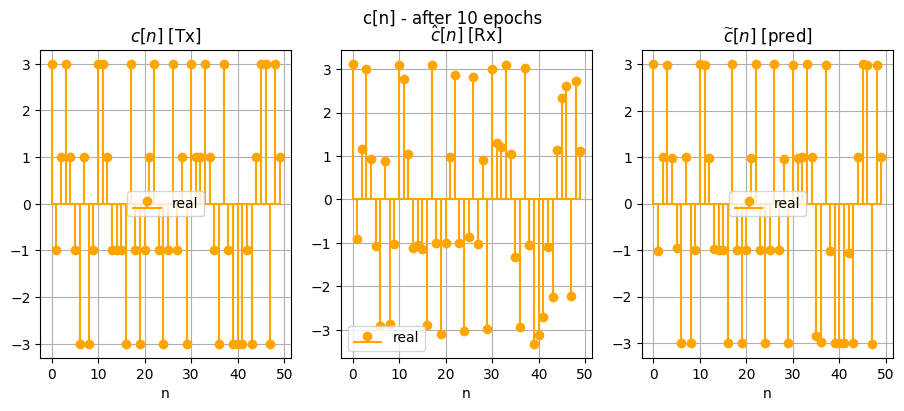

In [61]:
ma.plot_stems(i=1, zm_indices=range(0,50))

# analyze constelation

  0%|          | 0/150 [00:00<?, ?it/s]

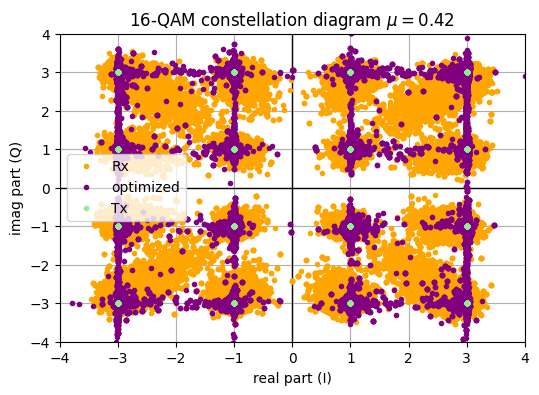

In [62]:
ma.plot_constelation(range(0,150), colors=['orange', 'purple', 'lightgreen'], is_annotate=False)

In [63]:
# x_power_i, y_power, pred_power = ma.calc_norms(_tqdm=tqdm, verbose_level=1, max_items=10000)
# print(f'x_power: {x_power_i}\ny_power: {y_power}\npred_power: {pred_power}')

In [64]:
# ma.upload_single_item_plots_to_wandb(1)

In [65]:
ma.plot_bers(_tqdm=tqdm, verbose_level=1,num_x_per_folder=50)

  0%|          | 0/50 [00:00<?, ?it/s]

the original avg ber (of validation set) is 0.009580078125


  0%|          | 0/50 [00:00<?, ?it/s]

the trained avg ber (of validation set) is 0.002119140625
the ber improvement is 77.88%


In [66]:
ma.upload_bers_to_wandb()

the original avg ber (of validation set) is 0.009358208550347222


KeyboardInterrupt: 

# test all BERs

In [ ]:
# add powers

# from apps.deep.power_adder import PowerAdder


# power_adder = PowerAdder(is_overright=True, verbose_level=2)
# power_adder.calculate_and_add_powers(main_ds_path)
# power_adder.replace_key_in_config_files(main_ds_path)

  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.100 | org_ber=5.69e-03 | model_ber=2.30e-02 |  ber_improve=-304%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.140 | org_ber=2.51e-04 | model_ber=8.63e-03 |  ber_improve=-3343%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.170 | org_ber=1.95e-06 | model_ber=3.38e-03 |  ber_improve=-172940%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.210 | org_ber=2.34e-06 | model_ber=1.53e-03 |  ber_improve=-65064%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.240 | org_ber=1.56e-06 | model_ber=8.58e-04 |  ber_improve=-54818%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.280 | org_ber=1.95e-06 | model_ber=5.28e-04 |  ber_improve=-26925%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.310 | org_ber=9.18e-06 | model_ber=4.21e-04 |  ber_improve=-4488%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.350 | org_ber=3.04e-04 | model_ber=4.00e-04 |  ber_improve=-32%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.390 | org_ber=2.67e-03 | model_ber=6.53e-04 |  ber_improve=076%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.420 | org_ber=9.30e-03 | model_ber=9.84e-04 |  ber_improve=089%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.460 | org_ber=2.27e-02 | model_ber=6.10e-03 |  ber_improve=073%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.490 | org_ber=4.51e-02 | model_ber=1.48e-02 |  ber_improve=067%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.530 | org_ber=7.68e-02 | model_ber=3.08e-02 |  ber_improve=060%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.560 | org_ber=1.12e-01 | model_ber=5.42e-02 |  ber_improve=052%


  0%|          | 0/15000 [00:00<?, ?it/s]

  0%|          | 0/15000 [00:00<?, ?it/s]

mu=0.600 | org_ber=1.51e-01 | model_ber=8.49e-02 |  ber_improve=044%


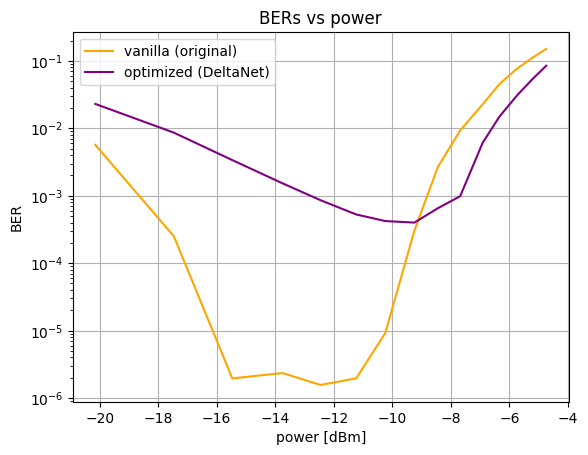

In [71]:
# main_ds_path = '/data/yarcoh/thesis_data/data/datasets/qam16_50x300/'

ma.plot_all_bers(base_path=main_ds_path, 
                 train_ds_ratio=0, 
                 val_ds_ratio=0, 
                 test_ds_ratio=0.5, 
                 _tqdm=tqdm, 
                 verbose_level=0.5,
                 is_upload_to_wandb=True,
                 power_instead_mu=True,)
                    

In [ ]:
# upload to wandb
# ma.upload_all_bers_to_wandb(base_path=main_ds_path,
#                  train_ds_ratio=0, 
#                  val_ds_ratio=0, 
#                  test_ds_ratio=0.15, 
#                  _tqdm=tqdm, 
#                  verbose_level=0.5)

In [ ]:
print('done')

# THE END

In [ ]:
# # paper 1 model analyzer
# path_init = '../../data/test_models/mu-0.008__128ds__PaperNNforNFTmodel__3epochs'

# trainer_real = Trainer.load3(path_init + '__real')
# trainer_imag = Trainer.load3(path_init + '__imag')

# train_ds = SingleMuDataSet(trainer_real.train_dataset.data_dir_path,
#                            trainer_real.train_dataset.data_indices)
# val_ds = SingleMuDataSet(trainer_real.val_dataset.data_dir_path,
#                          trainer_real.val_dataset.data_indices)

# model = PaperNNforNFTwrapper(trainer_real.model, trainer_imag.model)

# trainer = Trainer(
#     train_dataset=train_ds,
#     val_dataset=val_ds,
#     model=model,
#     device=trainer_real.device,
#     batch_size=trainer_real.train_dataloader.batch_size,
#     l_metric=trainer_real.l_metric,
#     optim=trainer_real.optim,
#     params=trainer_real.params)

In [ ]:
# analyze on the whole dataset

# attach new dataset to trainer


In [ ]:
# trainer.params

In [ ]:
# ma = ModelAnalyzer(trainer)

In [ ]:
# ma.plot_single_item(i=0)

In [ ]:
# ma.plot_bers(_tqdm=tqdm)